In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import numpy as np
import matplotlib.pyplot as plt
fig_width = 12
%matplotlib inline

In [2]:
import bayesianchangepoint as bcp


## performing inference: application to experimental data


get your trump data:

https://github.com/bpb27/trump_tweet_data_archive

In [3]:
from io import BytesIO
from zipfile import ZipFile
import urllib.request
import json

datafile = 'trumpets.json'
datafile = '/tmp/trumpets.json'

try:
    with open(datafile, 'r') as f:
        data = json.load(f)
except:
    years = [8] #[2, 3, 4, 5, 6, 7]
    years = [6, 7]
    years = [2, 3, 4, 5, 6, 7, 8]
    years = [5, 6, 7]#, 8]



    data = []
    arctype = 'condensed'
    arctype = 'master'
    for year in years:
        url = urllib.request.urlopen("https://github.com/bpb27/trump_tweet_data_archive/blob/master/{arctype}_201{Y}.json.zip?raw=true".format(arctype=arctype, Y=str(year)))
        print('Downloading ', url, '...')
        with ZipFile(BytesIO(url.read())) as my_zip_file:
            for contained_file in my_zip_file.namelist():
                with my_zip_file.open(contained_file) as f:
                    #data.extend(json.load(f))
                    data.extend(json.loads(f.read().decode('utf-8')))
    with open(datafile, 'w') as f:
        json.dump(data, f)          

In [4]:
!ls -ltrh /tmp/*json

-rw-r--r--  1 laurentperrinet  wheel    53M Apr  9 11:32 /tmp/trumpets.json


In [22]:
!rm -fr /tmp/trumpets.json

In [5]:
n_tweets = len(data)
print('number ow tweets=', n_tweets)

number ow tweets= 16971


## example tweet

In [6]:
i_sample = 42
i_sample = 1973
d = data[i_sample]
d#.keys()#['followers_count']

{'contributors': None,
 'coordinates': None,
 'created_at': 'Tue Sep 29 03:51:52 +0000 2015',
 'entities': {'hashtags': [],
  'symbols': [],
  'urls': [],
  'user_mentions': [{'id': 18281493,
    'id_str': '18281493',
    'indices': [1, 9],
    'name': 'polina6',
    'screen_name': 'polina6'},
   {'id': 25073877,
    'id_str': '25073877',
    'indices': [11, 27],
    'name': 'Donald J. Trump',
    'screen_name': 'realDonaldTrump'}]},
 'favorite_count': 3251,
 'favorited': False,
 'geo': None,
 'id': 648706734270382080,
 'id_str': '648706734270382080',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'place': None,
 'retweet_count': 1306,
 'retweeted': False,
 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
 'text': '"@polina6: @realDonaldTrump MAN WITH A PLAN-THE BEST TAX PLAN! G

## learning to handle datetimes

https://docs.python.org/3/library/datetime.html


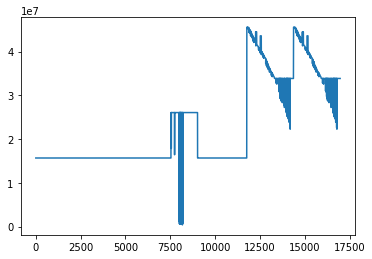

In [7]:
followers = [data[i]['user']['followers_count'] for i in range(n_tweets)]
plt.plot(followers);

In [8]:
data_texts = []
for i_tweet in range(n_tweets):
    try:
        data_texts.append(data[i_sample]['full_text'].lower())
    except KeyError:
        data_texts.append(data[i_sample]['text'].lower())

data_texts[i_sample]

'"@polina6: @realdonaldtrump man with a plan-the best tax plan! go trump 2016!"'

In [9]:
word = 'america'
word = '?'
contains_word = np.array([(word in data_text) for data_text in data_texts])
print(sum(contains_word), 'tweets contain the word "', word, '" on a total of ', n_tweets, 'tweets')

0 tweets contain the word " ? " on a total of  16971 tweets


In [10]:
datetimes = [data[i]['created_at'] for i in range(n_tweets)]
print('|'+datetimes[0]+'|')

|Thu Dec 31 23:21:49 +0000 2015|


In [11]:
import locale
locale.getlocale()

('en_US', 'UTF-8')

In [12]:
from datetime import datetime

datetimes = [datetime.strptime(data[i]['created_at'], '%a %b %d %H:%M:%S %z %Y') for i in range(n_tweets)]
print('Timestamp=', datetimes[0].timestamp())

Timestamp= 1451604109.0


In [13]:
from datetime import datetime

datetimes = np.array([datetime.strptime(data[i]['created_at'], '%a %b %d %H:%M:%S %z %Y').timestamp() for i in range(n_tweets)])
print('Timestamp=', (datetimes[0]))

Timestamp= 1451604109.0


In [14]:
from datetime import datetime

datetimes = [datetime.strptime(data[i]['created_at'], '%a %b %d %H:%M:%S %z %Y') for i in range(n_tweets)]
print('Timestamp=', datetimes[0].timestamp())

Timestamp= 1451604109.0


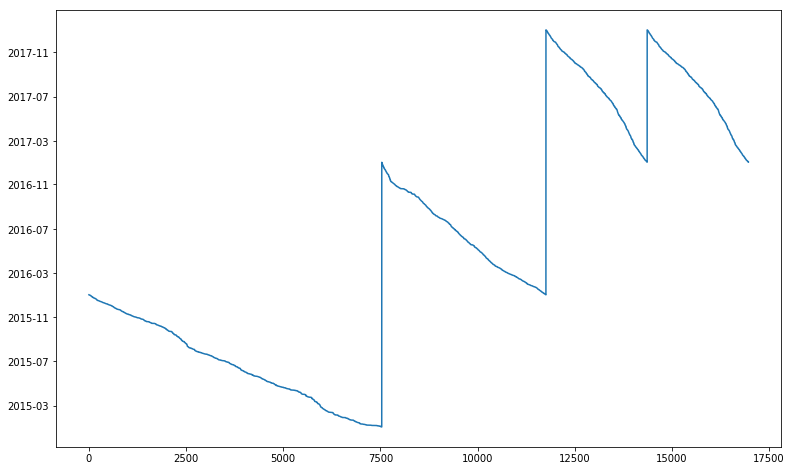

In [15]:
fig_width = 13
fig, ax = plt.subplots(figsize=(fig_width, fig_width/1.6180))
ax.plot(datetimes);

It seems that within each year, tweets are in inverse chronological order. 
Let's sort things:

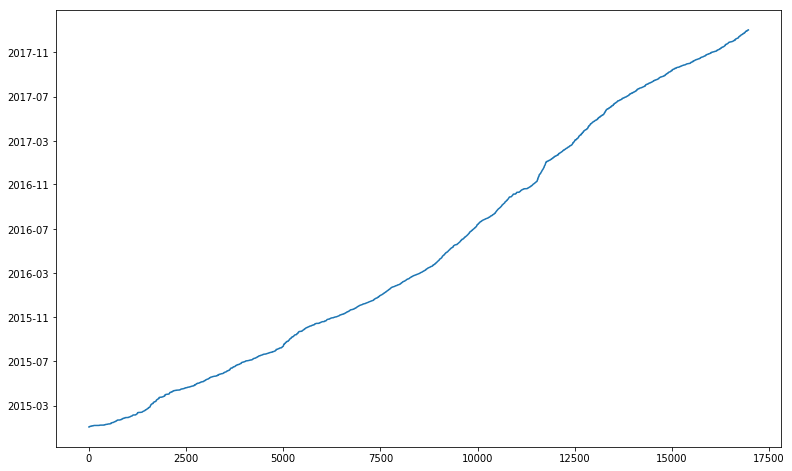

In [16]:
datetimes = np.array(datetimes)
ind_tweets = np.argsort(datetimes)

fig, ax = plt.subplots(figsize=(fig_width, fig_width/1.6180))
ax.plot(datetimes[ind_tweets]);

We will be using https://matplotlib.org/examples/api/date_demo.html

## evolution of followers

In [17]:
import datetime
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

monthsFmt = mdates.DateFormatter('%Y-%m')



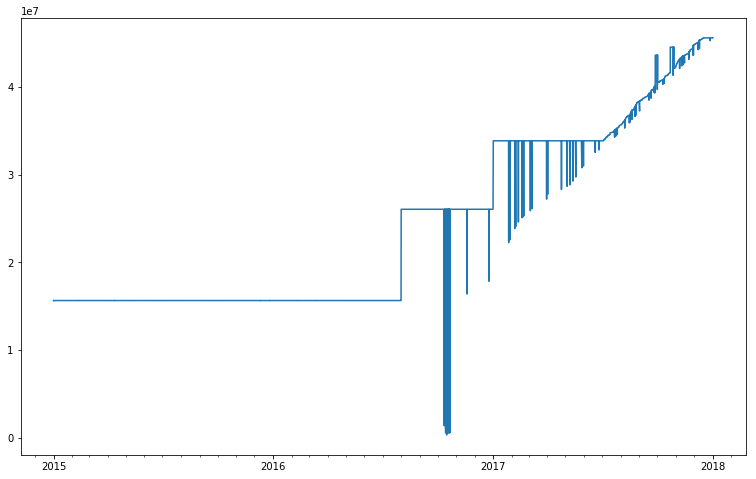

In [18]:
followers = np.array([data[i]['user']['followers_count'] for i in range(n_tweets)])

fig_width = 13
fig, ax = plt.subplots(figsize=(fig_width, fig_width/1.6180))
ax.plot(datetimes[ind_tweets], followers[ind_tweets])
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d');

In [19]:
i= 42
data_texts = []
for i in range(n_tweets):
    try:
        data_texts.append(data[i]['full_text'].lower())
    except KeyError:
        data_texts.append(data[i]['text'].lower())

data_texts[i]

'to all americans-\n#happynewyear &amp; many blessings to you all! looking forward to a wonderful &amp; prosperous 2017 as we… https://t.co/1asdmal4iy'

## detecting change points for using Android vs iPhone


Detecting tweets from staff (see http://varianceexplained.org/r/trump-tweets/)

In [24]:
data[i_sample]['source']

'<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>'

In [25]:
'iPhone' in data[i_sample]['source']

False

In [28]:
data_mobileos = np.array([('iPhone' in tweet['source']) for tweet in data])
print(sum(data_mobileos), 'tweets from an iPhone on a total of ', n_tweets, 'tweets')
p0 = sum(data_mobileos) / n_tweets
print('That is, an average probability of p0= ', p0)

6581 tweets from an iPhone on a total of  16971 tweets
That is, an average probability of p0=  0.38777915267220553


In [ ]:
for h in [1/1500/(2**k) for k in range(5)]:
    print('tau', 1/h)
    max_run_length = int(6/h)

    p_bar, r, beliefs = bcp.inference(data_mobileos[ind_tweets], h=h, p0=p0)

    fig, axs = bcp.plot_inference(data_mobileos[ind_tweets], None, p_bar, r, beliefs, mode='hindsight', max_run_length=max_run_length)
    ax = axs[-1]
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    plt.show()

tau 1500.0


In [ ]:
h = 1./10000
#max_run_length = 4500 #int(6/h)
p_bar, r_bar, beliefs = bcp.inference(data_mobileos[ind_tweets], h=h, p0=p0)#, max_T=max_run_length)

In [ ]:
p_hat, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode='hindsight')

In [ ]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width/1.6180))

p_hat[np.abs(np.gradient(p_hat))>.1] = np.nan
ax.plot(datetimes[ind_tweets], p_hat, c='r')

if True:
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
else:
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)


#ax.set_xlim(datetime.datetime(2015, 6, 15, 12, 21, 4, tzinfo=datetime.timezone.utc), datetime.datetime(2017, 12, 31, 18, 59, 4, tzinfo=datetime.timezone.utc))
ax.set_xlim(datetime.datetime(2015, 1, 1, 12, 21, 4, tzinfo=datetime.timezone.utc))

#ax.set_yscale('log')
ax.set_ylim(0, 1)

ax.set_xlabel('Date')
ax.set_ylabel('Estimated probability')    


## detecting change points for some words



In [42]:
word = 'america'
contains_word = np.array([(word in data_text) for data_text in data_texts])
print(sum(contains_word), 'tweets contain the word "', word, '" on a total of ', n_tweets, 'tweets')
p0 = sum(contains_word) / n_tweets
print('That is, an average probability of p0= ', p0)

2300 tweets contain the word " america " on a total of  16971 tweets
That is, an average probability of p0=  0.13552530787814507


In [43]:
h = 1/1500
max_run_length = int(6/h)
p0 = sum(contains_word) / n_tweets

In [44]:
p_bar, r, beliefs = bcp.inference(contains_word[ind_tweets], h=h, p0=p0)

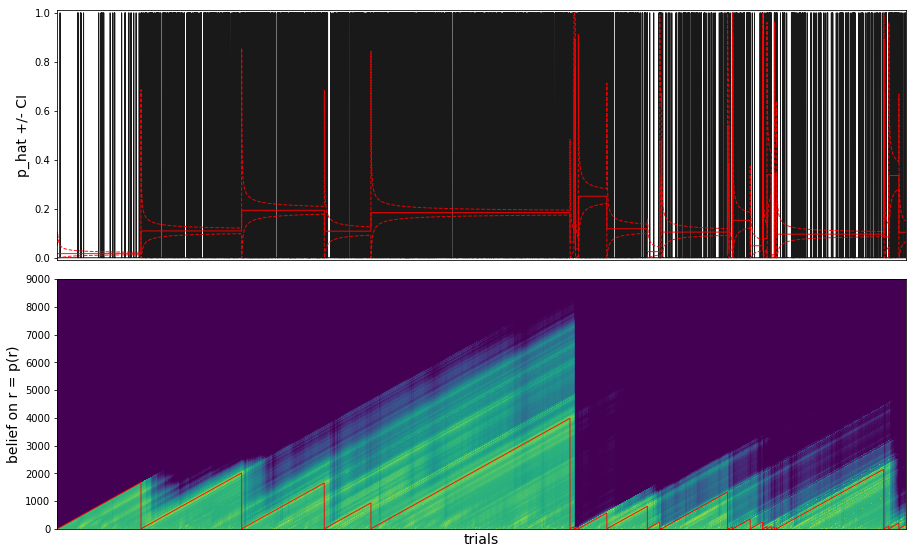

In [45]:
fig, axs = bcp.plot_inference(contains_word[ind_tweets], None, p_bar, r, beliefs, mode='hindsight', max_run_length=max_run_length)
ax = axs[-1]
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

## wraping things up

In [46]:
!ls -ltr -fr /tmp/data_cache

total 20247456
drwxr-xr-x  6 laurentperrinet  wheel         192 Apr  9 11:34 .
drwxrwxrwt  7 root             wheel         224 Apr  9 12:25 ..
-rw-r--r--  1 laurentperrinet  wheel  2590851168 Apr  9 11:33 news.npz
-rw-r--r--  1 laurentperrinet  wheel  2590851168 Apr  9 11:34 russia.npz
-rw-r--r--  1 laurentperrinet  wheel  2590851168 Apr  9 11:34 america.npz
-rw-r--r--  1 laurentperrinet  wheel  2590851168 Apr  9 11:33 fake.npz


In [47]:
def analyze(words, mode_, fig_width=8):
    
    
    
    fixed_window_size = 200


    fig, ax = plt.subplots(figsize=(fig_width, fig_width/1.6180))


    print ('mode', mode_)
    for word, c in zip(words, ['b', 'r', 'k', 'g']): #'?', '!', 

        filename = "/tmp/data_cache/" + word + ".npz"
        try:
            npzfile = np.load(filename)
            p_bar, r_bar, beliefs = npzfile['p_bar'], npzfile['r_bar'], npzfile['beliefs'] 
            #hack # to recompute files 
        except Exception as e:
            print('Computing for word' , word, ' - ', e)
            try:
                import os
                os.mkdir('/tmp/data_cache')
            except:
                pass

            contains_word = np.array([(word in data_text) for data_text in data_texts])
            p0 = sum(contains_word) / n_tweets

            p_bar, r_bar, beliefs = bcp.inference(contains_word[ind_tweets], h=h, p0=p0)#, max_T=max_run_length)

            np.savez(filename, p_bar=p_bar, r_bar=r_bar, beliefs=beliefs)

        if mode_=='fixed': 
            p_hat, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode=mode_, fixed_window_size=fixed_window_size)
        else:
            p_hat, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode=mode_)

        if mode_=='hindsight':
            print (np.gradient(p_hat).min(), np.gradient(p_hat).max())
            highgrad = np.abs(np.gradient(p_hat)) > .2
            p_hat[highgrad] = p_hat[highgrad+1]

        ax.plot(datetimes[ind_tweets], p_hat, c=c, label=word)
        #ax.plot(datetimes)


    #datemin = datetime.date(datetimes.min(), 1, 1)
    #datemax = datetime.date(datetimes.max() + 1, 1, 1)
    #ax.set_xlim(datemin, datemax)
    if True:
        ax.xaxis.set_major_locator(years)
        ax.xaxis.set_major_formatter(yearsFmt)
        ax.xaxis.set_minor_locator(months)
    else:
        ax.xaxis.set_major_locator(months)
        ax.xaxis.set_major_formatter(monthsFmt)
    #ax.xaxis.set_minor_locator(months)
    #ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    #ax.set_yscale('log')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

    ax.set_xlabel('Date')
    ax.set_ylabel('Estimated probability')    
    ax.legend(loc='best')
    #ax.set_xlim(datetime.datetime(2015, 6, 15, 12, 21, 4, tzinfo=datetime.timezone.utc), datetime.datetime(2017, 12, 31, 18, 59, 4, tzinfo=datetime.timezone.utc))

    ax.set_xlim(datetime.datetime(2015, 1, 1, 12, 21, 4, tzinfo=datetime.timezone.utc))
    ax.set_ylim(0, 1)


    return fig, ax

modes = ['fixed', 'expectation', 'max', 'hindsight', ]
modes = ['fixed', 'hindsight', ]


for words in [['fake', 'news', 'america', 'russia'], 
              ['obama', 'hillary', 'putin', 'pence'],
              ['golf', 'crazy', 'weak', 'joke'],
              ['obama', 'hillary', 'crooked', 'CNN'],
              ['covfefe', 'counsel', 'crooked', 'lightweight'],
              ['great', 'amazing', 'bad', 'sad'],
             ]:
    for i_mode, mode_ in enumerate(modes):
        fig, ax = analyze(words, mode_)
        plt.show()
        import os
        fig.savefig(os.path.join('../../AnticipatorySPEM/figures', 'trump_' + mode_ + '.png'), dpi=400)


mode fixed


ValueError: x and y must have same first dimension, but have shapes (16971,) and (10390,)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x112f0d488> (for post_execute):


ValueError: view limit minimum -0.001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -0.001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 576x355.995 with 1 Axes>

In [ ]:
ax.set_xticklabels?


In [ ]:
datetimes

## future

In [ ]:
break

Use a http://textblob.readthedocs.io/en/dev/ to extract ``sentiment.polarity`` / or if all words are correct using Spelling Correction / see also http://text-processing.com/docs/sentiment.html

Use http://www.nltk.org/book/ch02.html to compute relative word frequencies.

In [ ]:
!pip3 install textblob

In [ ]:
!ipython -m textblob.download_corpora

In [ ]:
from textblob import TextBlob

text = '''
The titular threat of The Blob has always struck me as the ultimate movie
monster: an insatiably hungry, amoeba-like mass able to penetrate
virtually any safeguard, capable of--as a doomed doctor chillingly
describes it--"assimilating flesh on contact.
Snide comparisons to gelatin be damned, it's a concept with the most
devastating of potential consequences, not unlike the grey goo scenario
proposed by technological theorists fearful of
artificial intelligence run rampant.
'''

blob = TextBlob(text)
blob.tags           # [('The', 'DT'), ('titular', 'JJ'),
                    #  ('threat', 'NN'), ('of', 'IN'), ...]

blob.noun_phrases   # WordList(['titular threat', 'blob',
                    #            'ultimate movie monster',
                    #            'amoeba-like mass', ...])

for sentence in blob.sentences:
    print(sentence.sentiment.polarity)
# 0.060
# -0.341

blob.translate(to="fr")  # 'La amenaza titular de The Blob...'

